In [72]:
import re
import json
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor
from scipy import stats

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage

In [73]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Change whether the pipeline uses the CD3.1 data or CD3.3 data by changing `fr_raw`

In [74]:
fr_raw = pd.read_csv(r'..\data\search\CD31\peak_finder\Final_Results_CD31.csv')
# fr_raw = pd.read_csv('../data/search/CD33/peak_finder_CD33_filter/Final_Results_CD33_filter.csv')
fr_raw = fr_raw.drop(fr_raw.filter(regex='Unnamed').columns, axis=1)  # filter out the "Unnamed: " column 



,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
0,0.536,679.05463,+,24.521584,NaN,NaN,49,12.760567,12.814706,23.449534,...,24.078826,23.973553,23.704492,23.902772,23.621358,23.690532,23.698050,13.072886,12.921021,12.867546
1,0.537,641.10870,+,25.718750,NaN,NaN,36,12.275439,12.329578,25.479163,...,25.199421,25.314548,22.568559,25.351072,25.175649,24.940494,24.784154,12.548870,12.361148,12.373940
2,0.541,951.15973,-,24.948650,NaN,NaN,10,14.929743,12.711860,23.954770,...,23.904184,24.189027,23.536612,24.279844,24.219057,24.219869,23.879666,13.267578,16.531875,16.150542
3,0.542,329.03067,-,28.102881,NaN,NaN,55,15.112058,12.894175,26.943018,...,28.102881,26.767826,27.114242,27.393906,27.736472,27.416002,27.298977,17.847537,16.714190,16.332857
4,0.544,969.13147,-,24.016735,NaN,NaN,14,15.142014,12.924130,23.376761,...,22.649320,22.935875,22.053092,23.432892,23.310997,22.997359,23.111055,17.877492,16.744145,16.362813
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,20.175,593.58716,+,21.652712,NaN,NaN,19,13.716785,13.856031,20.780617,...,17.866990,20.300784,18.139097,19.704856,19.272127,20.651849,17.672171,13.960918,13.906388,13.895536
1483,20.196,871.80945,+,21.307764,NaN,NaN,6,13.447439,13.536660,20.007142,...,16.278306,19.701052,16.436508,18.897814,16.912048,20.005751,15.379172,13.641548,13.492289,13.459704
1484,20.435,1003.93829,+,21.611359,NaN,NaN,4,13.632066,13.754376,19.156770,...,18.384443,18.569765,19.593862,17.543428,20.129772,18.758541,19.071444,14.503680,13.849520,14.123165
1485,20.452,1164.01404,+,21.611875,NaN,NaN,2,13.747059,13.803365,14.027172,...,17.944167,14.315627,19.464863,14.898737,20.065866,14.799675,19.013982,14.552670,13.898510,14.172155


## Process Notes:

1. Remove blank and water samples (5 total)

2. Separate into control vs test groups

3. Create 2nd pandas table of metadata compiled from Huishi's metadata info spreadsheet:
    1. "20210421_FBGRBGOGTT_Huishi sample sheet.xlsx"
    2. Include timepoints in pd.datetime format
    3. Include each rat's phenotypes (glucose level, insulin, weight, age, etc.) 
    
4. Explanation of sample metadata:
    1. Rat names: "T1060M", "T1061M", ... "T1102M" (not all number
        1. Not all numbers between 1060 and 1102 are included.
        2. NB: Not all rats had samples submitted for MS lipidomics
        
    2. RBG vs FBG 
        1. RBG = random blood glucose (randomly sampled blood glucose levels)
        2. FBG = fasted blood glucose (collected after fasting at pre-determined time intervals)
        
    3. Age
        1. Date of birth, between 1/23/2021 and 2/1/2021
        2. Metadata from Huishi organized based on "X weeks old" 
            1. Time points: 4, 8, 9, 10, 11, 12 weeks old 
            
     4. Weight
         1. Weights given as around 100, I assume this is grams
         2. Also gives "Weight gain %" or "Weight loss %"
         3. Also includes "Weight (pre-fasting)"
         3. Also includes "4 to 8 weeks" "Weight gain %"
         5. One of the weights has a note "euthanized due to tail injury" and blanks for that rat thereafter
            
     5. Date and time
         1. Given in "When" column
         2. Formats given as "3/26 6pm" or "4/10 10:30am" or "03/29 10:30am" 
      
    10. Other metadata:
        1. Note at top of metadata spreadsheet: "Fasting from 6:30pm to 10:30am; Light cycle 10am to 10pm"
            1. Referring to fasting periods for nile rats, and when the lights were on/off in the room
        2. "Collected hypothalamus, interscapular white fat, interscapular brown fat, inguinal white fat, mesenteric visceral white rat, pancreas, duodenum, jejunum, ileum, liver,"
        3. "Isoflurane 3% with 2L/min oxygen (~2min to go under)"
        4. Under the post-mortem phenotypes: "Used pre-fasting weight to calculate amount of dextrose"


## Is there a run order dependence on median feature quant?

### Fitting regression to file median quant shows significant upward slope

### Fitting regression to individual feature values also shows generally the same upward slope 

slope:  0.009300035573067257
y-intercept:  23.104750098276497


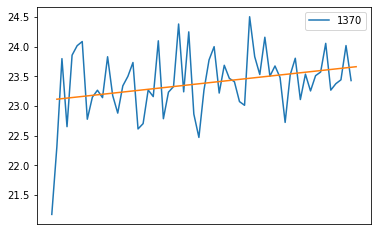

In [75]:
runorder = fg.sort_values('lipid_run_order')['fr_name']
feat = fr_raw.sample()[runorder].T
feat.plot(xticks=[])
# get linear regression of data
fit = np.polyfit(x=range(1,feat.shape[0]+1), y=feat, deg=1)
print('slope: ', fit[0][0])
print('y-intercept: ', fit[1][0])
x = np.arange(1, feat.shape[0] + 1, dtype='float64')
plt.plot(x, (fit[0] * x + fit[1]))
plt.show()

### Histogram of slopes of regression lines for individual features is a normal distribution centered at 0.01

### Suggests there is average quantitation dependence on analytical order

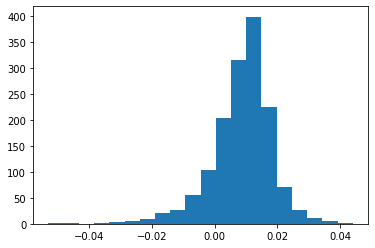

In [76]:
## Calculate all linear regression fits for all features and show histogram of slopes
fit_slopes = []
for index, row in fr_raw[runorder].iterrows():
    fit = LinearRegression().fit(np.arange(0,60).reshape(-1, 1), row.T)
    fit_slopes.append(fit.coef_[0])
plt.hist(fit_slopes, bins=20);

0.0006620004500282673
0.008878705098912027
20.678730657228176
[0.00887871]
0.18256229706582738
[1.         0.99957082 0.99914201 0.99871356 0.99828549 0.99785778
 0.99743043 0.99700346 0.99657685 0.9961506  0.99572472 0.9952992
 0.99487404 0.99444925 0.99402482 0.99360075 0.99317705 0.9927537
 0.99233072 0.99190809 0.99148583 0.99106393 0.99064238 0.99022119
 0.98980037 0.98937989 0.98895978 0.98854002 0.98812062 0.98770157
 0.98728288 0.98686455 0.98644657 0.98602894 0.98561167 0.98519475
 0.98477818 0.98436196 0.9839461  0.98353058 0.98311542 0.98270061
 0.98228615 0.98187203 0.98145827 0.98104485 0.98063179 0.98021907
 0.9798067  0.97939467 0.97898299 0.97857166 0.97816067 0.97775003
 0.97733973 0.97692978 0.97652017 0.9761109  0.97570198 0.9752934 ]


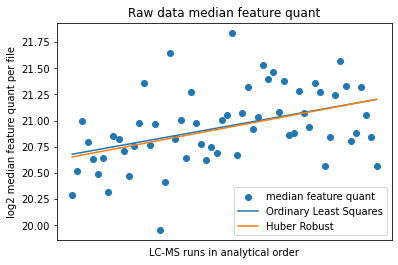

In [140]:
# plots of the medians of each non-QC, non-blank file's quant
file_medians = fr_raw[runorder].median(axis=0)

model = LinearRegression().fit(np.arange(0, file_medians.shape[0]).reshape(-1,1), file_medians)
huber = HuberRegressor(epsilon=1.35).fit(np.arange(0, file_medians.shape[0]).reshape(-1,1), file_medians)

# Using scipy stats module to get p_value easily 
slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0, file_medians.shape[0]), file_medians)
print(p_value)
print(slope)
print(intercept)
print(model.coef_)
print(model.score(np.arange(0, file_medians.shape[0]).reshape(-1,1), file_medians))

fig, ax = plt.subplots()
ax.scatter(range(60), file_medians, label='median feature quant')
ax.plot(np.arange(0,60), np.arange(0,60) * model.coef_ + model.intercept_, label='Ordinary Least Squares')
ax.plot(np.arange(0, 60).T, (np.arange(0,60) * huber.coef_) + huber.intercept_, label='Huber Robust')
plt.legend()
plt.ylabel('log2 median feature quant per file')
plt.xlabel('LC-MS runs in analytical order')
plt.title('Raw data median feature quant')
plt.xticks([])

normalization_factor_arr = np.arange(0, 60)*slope + intercept 
normalization_factor_arr = (normalization_factor_arr[0] / normalization_factor_arr)
print(normalization_factor_arr)

# plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\median feature quant raw.png')

new slope after normalization:  3.592695205228244e-05 --> is very close to 0


,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11),...,20210729_AJ_Toh_RatBloodGlucose_T1092M_20210410_10wk_FBG.raw (F45),20210729_AJ_Toh_RatBloodGlucose_T1082M_20210325_8wk_RBG.raw (F30),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210325_8wk_RBG.raw (F10),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1093M_20210330_8wk_RBG.raw (F48),20210729_AJ_Toh_RatBloodGlucose_T1074M_20210329_9wk_FBG.raw (F19),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210401_9wk_RBG.raw (F14),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210330_8wk_RBG.raw (F54),20210729_AJ_Toh_RatBloodGlucose_T1092M_20210330_8wk_RBG.raw (F42),20210729_AJ_Toh_RatBloodGlucose_T1092M_20210413_10wk_RBG.raw (F46)
0,0.536,679.05463,+,24.421692,NaN,NaN,49,12.760567,12.814706,19.386742,...,22.462249,23.360916,22.399150,23.163419,22.737840,22.116533,23.352451,23.527438,23.858693,23.617549
1,0.537,641.10870,+,25.685664,NaN,NaN,36,12.275439,12.329578,18.127080,...,24.663849,23.700392,23.382317,24.385568,23.789670,22.248759,22.513249,24.558075,24.818525,24.575904
2,0.541,951.15973,-,24.916555,NaN,NaN,10,14.929743,12.711860,18.932322,...,23.452626,22.549975,23.249352,23.680978,23.989589,23.527507,24.002570,23.886203,24.069137,23.455789
3,0.542,329.03067,-,27.946889,NaN,NaN,55,15.112058,12.894175,22.605415,...,27.210668,26.194952,26.911119,26.805997,26.145097,26.638404,27.217392,26.970428,27.175265,26.482705
4,0.544,969.13147,-,23.985839,NaN,NaN,14,15.142014,12.924130,17.544156,...,22.602208,21.905509,22.226570,22.485669,22.208159,22.236114,23.151359,22.823820,21.750593,22.047030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,20.175,593.58716,+,21.430516,NaN,NaN,19,13.716785,13.856031,15.868179,...,18.815858,18.693961,18.778798,20.192346,17.113028,18.925197,17.773412,17.541022,16.974304,16.687194
1483,20.196,871.80945,+,21.063577,NaN,NaN,6,13.447439,13.536660,17.603903,...,18.126555,17.059262,16.471090,19.560624,15.553916,17.922820,15.791324,15.832797,14.273751,13.966980
1484,20.435,1003.93829,+,21.327484,NaN,NaN,4,13.632066,13.754376,14.577668,...,15.806144,19.437801,19.285159,18.341164,17.789158,16.157526,18.489770,15.604317,17.785595,17.407656
1485,20.452,1164.01404,+,21.327993,NaN,NaN,2,13.747059,13.803365,13.958268,...,13.696410,19.076223,19.153323,14.470383,16.674338,13.623353,18.255379,16.626323,17.266588,15.048004


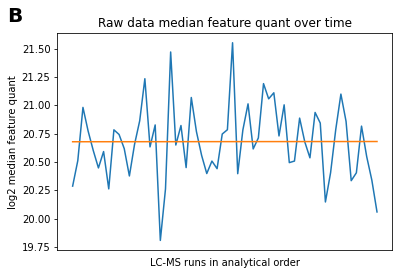

In [78]:
# Multiply each column by a factor that depends on the column index:
# Col 1 is multiplied by 1
# Col 2 multiplied by 0.99
# Col 3 by 0.98 ... 
# Using the slope and intercept from stats.linregress above:

normalization_factor_arr = np.arange(0, 60)*slope + intercept 
normalization_factor_arr = (normalization_factor_arr[0] / normalization_factor_arr)

fr_norm = fr_raw[runorder] * normalization_factor_arr
fr_norm.median(axis=0).plot()
_slope, _intercept, _r_value, _p_value, _std_err = \
    stats.linregress(np.arange(0, file_medians.shape[0]), fr_norm.median(axis=0))

plt.plot(np.arange(0,60), (np.arange(0,60)*_slope + _intercept))
ax = plt.gca()
ax.text(-0.15, 1.05, "B", transform=ax.transAxes, fontsize=20, weight='bold')
plt.ylabel('log2 median feature quant')
plt.xlabel('LC-MS runs in analytical order')
plt.title('Raw data median feature quant over time')
plt.xticks([]);
# plt.savefig(r'..\reports\collaborator reports\preliminary 20210812\figures\median feature quant normalized.png')

print("new slope after normalization: ", _slope, "--> is very close to 0")

fr_norm = fr_raw.loc[:, ~fr_raw.columns.isin(runorder)].join(fr_norm)
fr_norm['Area (max)'] = fr_norm.filter(regex='.raw').max(axis=1)
# fr_norm.to_csv(r'..\data\processed\lipidomics_linregress_normalized_data.csv', index=False)
# fr_norm = pd.read_csv(r'..\data\processed\lipidomics_linregress_normalized_data.csv')
fr_norm

## Filtering features 

1.  Filter on RSDs of the 2 QCs, using a cutoff of 0.5 (50%)
2.  Add a ‘unique identifier’ label which concatenates RT_quantmz_lipid_id (or unknown)
3.  Add unknown label to ID and class for unknowns
4.  Filter out all features found in 2 or 3 files


<AxesSubplot:>

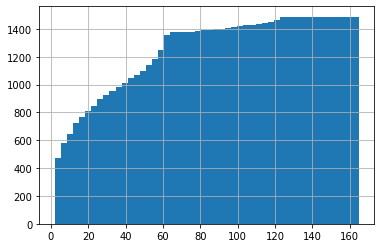

In [79]:
fr_norm['Features Found'].hist(bins=50, cumulative=True)
# plt.xlim(0, 150)

### As expected, RSDs for all data are higher than data for QC
### But don't over-interpret, there are only 2 QC files 

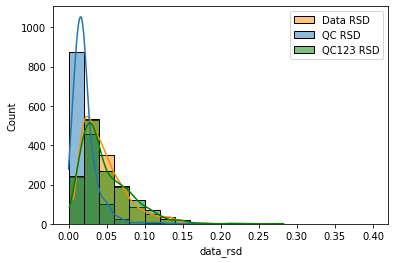

In [80]:
data_cols = fg['fr_name']
# high_RSD_rows = fr_norm[(fr_norm.filter(regex='QC2|QC3').std(axis=1)/fr_norm.filter(regex='QC2|QC3').mean(axis=1)) > 0.5].index
fr_filt = fr_norm.copy()
# fr_filt.loc[fr_filt['Identification'].notna()]
fr_filt['qc_rsd'] = (fr_filt.filter(regex='QC2|QC3').std(axis=1)/fr_filt.filter(regex='QC2|QC3').mean(axis=1))
fr_filt['qc123_rsd'] = (fr_filt.filter(regex='QC').std(axis=1)/fr_filt.filter(regex='QC').mean(axis=1))
fr_filt['data_rsd'] = fr_filt[data_cols].std(axis=1) / fr_filt[data_cols].mean(axis=1)
sns.histplot(fr_filt['data_rsd'], alpha=0.5, binwidth=0.02, binrange=(0, 0.4), 
             color='darkorange', label='Data RSD', kde=True)
sns.histplot(fr_filt['qc_rsd'], alpha=0.5, binwidth=0.02, binrange=(0, 0.4), 
             label='QC RSD', kde=True)
sns.histplot(fr_filt['qc123_rsd'], alpha=0.5, binwidth=0.02, binrange=(0, 0.4), 
             label='QC123 RSD', color='green', kde=True)
plt.legend()

## Can we recover QC1 by scaling up? 
## This is not recommended 

0.7830990988594496

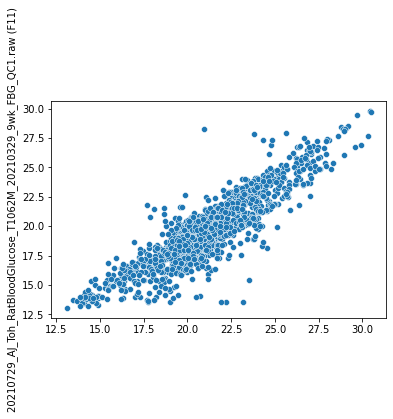

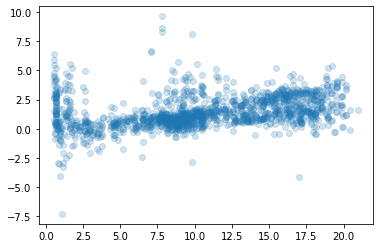

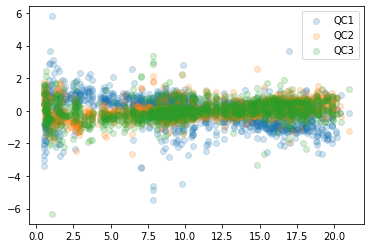

In [81]:
qc23avg = fr_filt.sort_values('Retention Time (min)').filter(regex='QC2|QC3').mean(axis=1)
qc123avg = fr_filt.filter(regex='QC').mean(axis=1)
qc1 = fr_filt.sort_values('Retention Time (min)').filter(regex='QC1').iloc[:, 0]
sns.scatterplot(x=qc23avg, y=qc1)

## Is there a RT dependence on diffrence between QC2&3 and QC1?
plt.figure()
plt.scatter(x=fr_filt.sort_values('Retention Time (min)')['Retention Time (min)'],
            y=qc23avg-qc1,
            alpha=0.2)

plt.figure()
qc1_avg_dev = (qc123avg - fr_filt.filter(regex='QC1').values[:, 0]).mean()
qc2_avg_dev = (qc123avg - fr_filt.filter(regex='QC2').values[:, 0]).mean()
qc3_avg_dev = (qc123avg - fr_filt.filter(regex='QC3').values[:, 0]).mean()

## What does each QC quant look like along the RT space? 
qc123avg = fr_filt.filter(regex='QC').mean(axis=1)
plt.scatter(x=fr_filt['Retention Time (min)'], 
            y=fr_filt.filter(regex='QC1').values[:, 0] - qc123avg + qc1_avg_dev, 
            label='QC1', alpha=0.2)
plt.scatter(x=fr_filt['Retention Time (min)'], 
            y=fr_filt.filter(regex='QC2').values[:, 0] - qc123avg + qc2_avg_dev, 
            label='QC2', alpha=0.2)
plt.scatter(x=fr_filt['Retention Time (min)'], 
            y=fr_filt.filter(regex='QC3').values[:, 0] - qc123avg + qc3_avg_dev, 
            label='QC3', alpha=0.2)
plt.legend()

## What is the R2 value of the fit between QC2&3 and QC1? 
qcfit = LinearRegression().fit(qc23avg.values.reshape(-1, 1), qc1.values.reshape(-1, 1))
qcfit.intercept_
qcfit.score(qc23avg.values.reshape(-1, 1), qc1.values.reshape(-1, 1))

### In the QC RSDs, there are distinct clumps of 60 and 120 Features Found 

Text(0.5, 1.0, 'QC 1&2&3 RSDs vs. LipiDex Features Found')

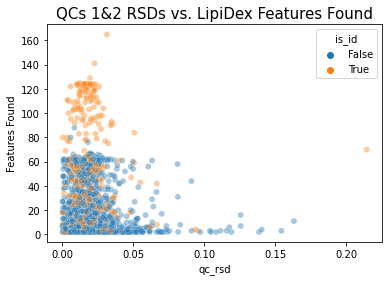

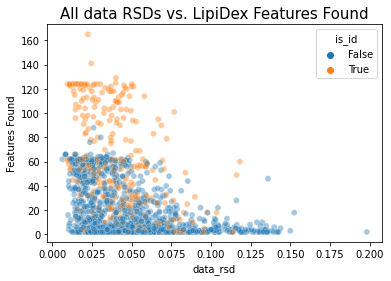

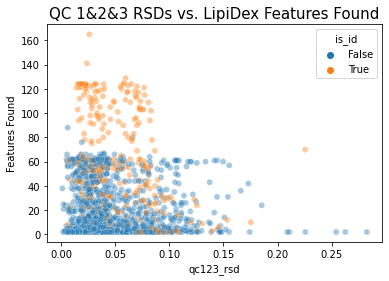

In [82]:
# QC RSD vs Features Found plot
fr_filt['is_id'] = fr_filt['Lipid Class'].notna()
sns.scatterplot(data=fr_filt, x='qc_rsd', y='Features Found', hue='is_id', alpha=0.4)
plt.title('QCs 1&2 RSDs vs. LipiDex Features Found', fontsize=15)
plt.figure()
sns.scatterplot(data=fr_filt, x='data_rsd', y='Features Found', hue='is_id', alpha=0.4)
plt.title('All data RSDs vs. LipiDex Features Found', fontsize=15)
plt.figure()
sns.scatterplot(data=fr_filt, x='qc123_rsd', y='Features Found', hue='is_id', alpha=0.4)
plt.title('QC 1&2&3 RSDs vs. LipiDex Features Found', fontsize=15)

## Untargeted metabolomics Quality control methods: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6570933/
### "Data-adaptive feature filtering" 
### 1. Filtering on blank samples
    - common approach is to use fold change difference cut-off
    - they recommend MD-plot (mean-difference)


### Filtering features by percent missing (#2) is also not possible, because I did not pre-screen the dataset in CD to make list of high-quality and low-quality features. 

### Filtering based on Intra-class correlation (ICC) assumes you have sufficient replicate pooled QCs, or replicates of your biological samples.
# Overall, this paper's methods cannot apply to this dataset

## Mean-difference (MD) plot

### Replication of the Figure 3 plot in the paper is not possible with data that has already been blank filtered. 
### The stepped cut-off lines (purple and green in paper) come from estimations of the noise distribution at each mean... Is that TOF-specific? 

In [83]:
fr_filt['sample_mean'] = fr_filt[runorder].mean(axis=1)
fr_filt['blank_mean'] = fr_filt.filter(regex='Blank').mean(axis=1)
fr_filt['blank_max'] = fr_filt.filter(regex='Blank').max(axis=1)
fr_filt['sample_blank_diff'] = fr_filt['sample_mean'] - fr_filt['blank_mean']
fr_filt['sample_maxblank_diff'] = fr_filt['sample_mean'] - fr_filt['blank_max']

In [84]:
quantile2 = fr_filt.loc[(fr_filt['sample_mean'] > 19.6) & (fr_filt['sample_mean'] < 20.65)]
quartile = quantile2['sample_blank_diff'].quantile(0.1)
quartile

3.8758991405302416

<AxesSubplot:xlabel='sample_mean', ylabel='sample_blank_diff'>

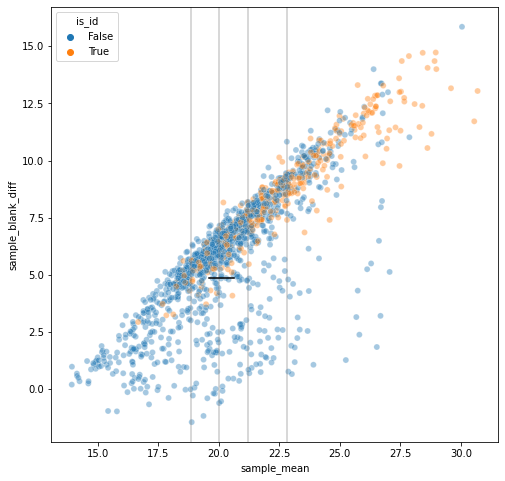

In [85]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
for quantile in [0.2, 0.4, 0.6, 0.8]:
    ax.axvline(fr_filt['sample_mean'].quantile(quantile), color='gray', alpha=0.4)
ax.plot([19.6, 20.65], [4.86, 4.86], color='black')
sns.scatterplot(data=fr_filt,
                y='sample_blank_diff', x='sample_mean', hue='is_id', alpha=0.4,
                ax=ax)

## Plot features below given `sample_blank_diff`

263


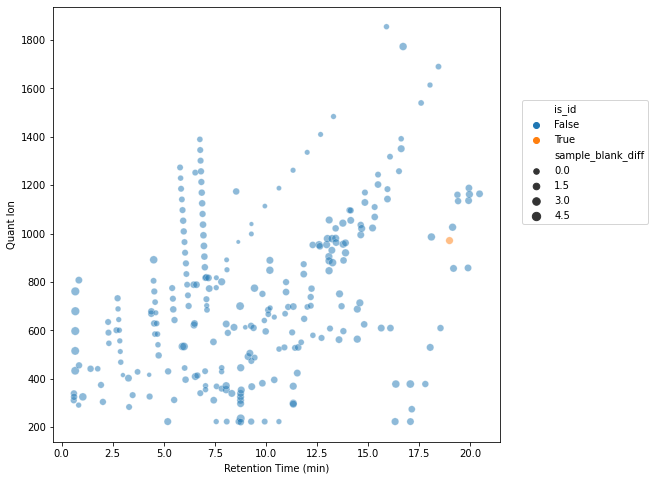

In [86]:
df = fr_filt.loc[fr_filt['sample_maxblank_diff'] < 3]
print(len(df))
sns.scatterplot(data=df, x='Retention Time (min)', y='Quant Ion', 
                hue='is_id', size='sample_blank_diff', alpha=0.5, )
plt.legend(loc=(1.05, 0.5))
plt.gcf().set_size_inches(8, 8)

## RT and m/z cutoffs 

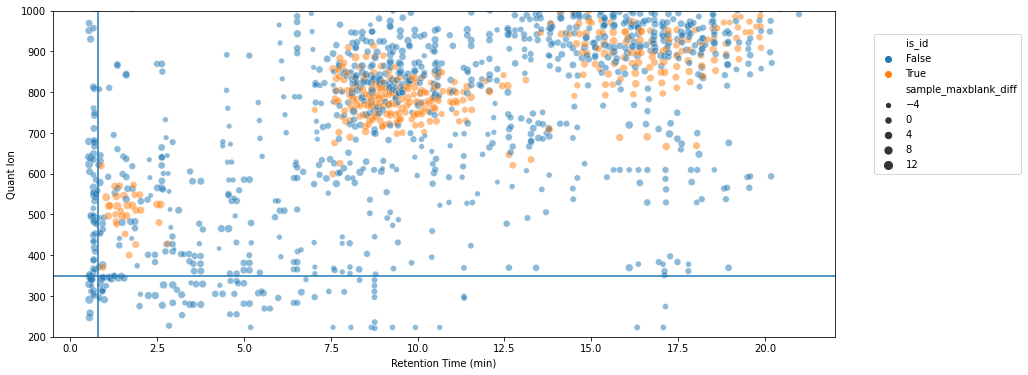

In [87]:
sns.scatterplot(data=fr_filt, x='Retention Time (min)', y='Quant Ion', 
                hue='is_id', size='sample_maxblank_diff', alpha=0.5)
plt.gcf().set_size_inches(14, 6)
plt.legend(loc=(1.05, 0.5))
plt.ylim(200, 1000)
plt.axvline(0.8)
plt.axhline(350)

### Features Found vs. Average quant

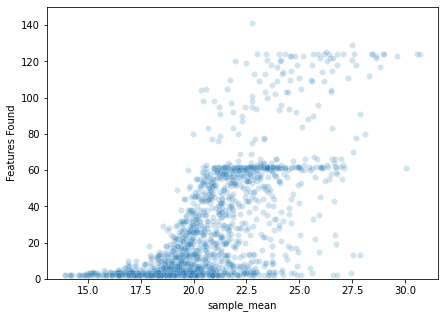

In [88]:
sns.scatterplot(data=fr_filt, 
                x='sample_mean', y='Features Found', alpha=0.2)
plt.ylim(0, 150)
plt.gcf().set_size_inches(7, 5)

### Sample mean vs RT

<AxesSubplot:xlabel='Retention Time (min)', ylabel='sample_mean'>

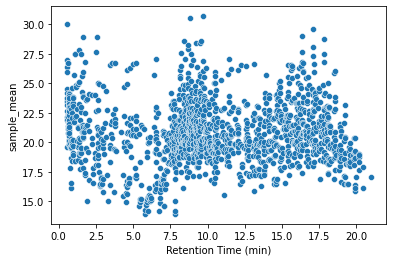

In [89]:
sns.scatterplot(data=fr_filt, y='sample_mean', x='Retention Time (min)')

## Distribution of Features Found based on `sample_mean` quantile

18.858401584448007
20.02365408724131
21.212145215164725
22.83901289666258
30.6920826456315


(0.0, 200.0)

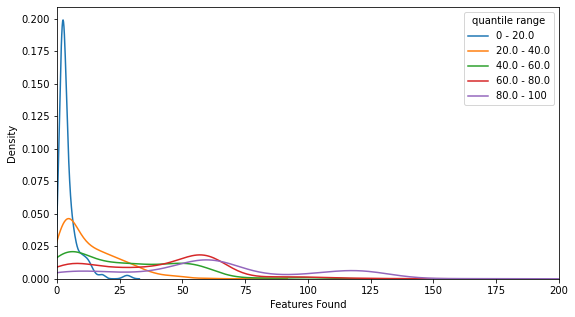

In [90]:
quantiles = [(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1)]
# quantiles = [(0, 0.2), (0.2, 0.8), (0.8, 1)]

for i, (q1, q2) in enumerate(quantiles):
    lower = fr_filt['sample_mean'].quantile(q1)
    upper = fr_filt['sample_mean'].quantile(q2)
    print(upper)
    sns.kdeplot(fr_filt.loc[(fr_filt['sample_mean'] > lower) & \
                            (fr_filt['sample_mean'] < upper), 'Features Found'], 
                label=f'{q1*100} - {q2*100}')
plt.gcf().set_size_inches(9, 5)
plt.legend(title='quantile range')
plt.xlim(0, 200)

<AxesSubplot:>

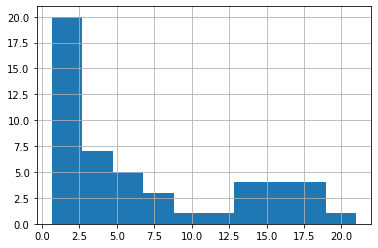

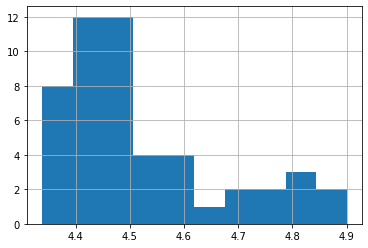

In [91]:
fr_filt.loc[fr_filt['qc_rsd'] > 0.06, 'Retention Time (min)'].hist()
plt.figure()
np.log2(fr_filt.loc[fr_filt['qc_rsd'] > 0.06, 'Area (max)']).hist()

## Plot of Features Found vs RT with RSD on marker size

(0.0, 150.0)

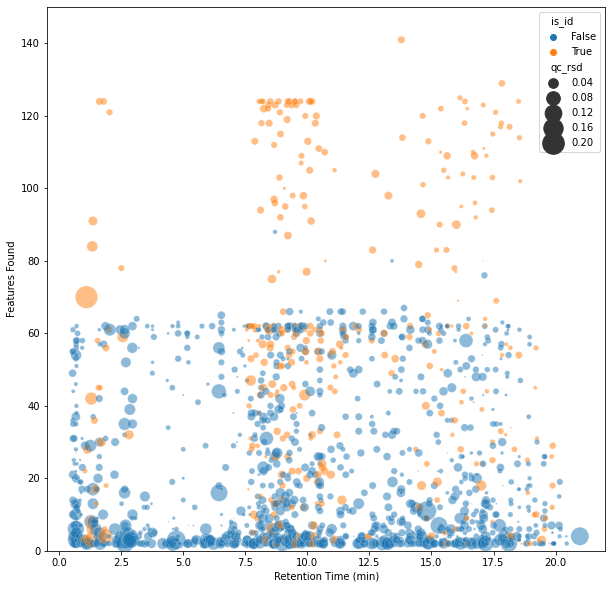

In [92]:
sns.scatterplot(data=fr_filt.loc[fr_filt['Area (max)'] > 10], 
                x='Retention Time (min)', y='Features Found', 
                hue='is_id', # 'is_id' 'Area (max)'
                size='qc_rsd', sizes=(1, 500),
#                 palette='viridis_r',
                alpha=0.5)
plt.gcf().set_size_inches(10, 10)
# plt.legend(loc=(1.01, 0.5))
plt.ylim(0, 150)

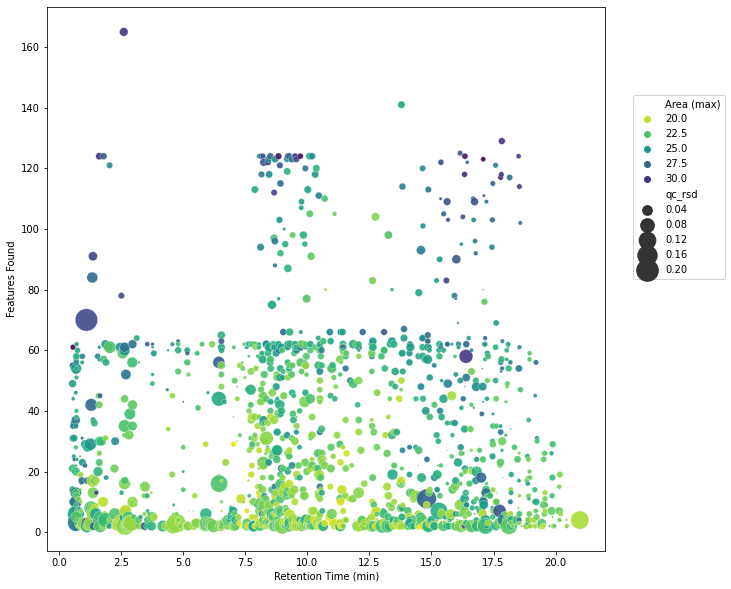

In [93]:
sns.scatterplot(data=fr_filt.loc[fr_filt['Area (max)'] > 10], 
                x='Retention Time (min)', y='Features Found', 
                hue='Area (max)', # 'is_id'
                size='qc_rsd', sizes=(1, 500),
                palette='viridis_r',
                alpha=0.9)
plt.gcf().set_size_inches(10, 10)
plt.legend(loc=(1.05, 0.5))

# Check for in-source fragments by clustering features that are below a certain distance threshold
# distance is calculated between features as 
### `ΔRT + (1 - correlation) + (0 if same polarity, inf otherwise)`

In [94]:
# calculate absolute value of RT deviation between each feature
rt_dist = squareform(pdist(fr_filt['Retention Time (min)'].values.reshape(-1, 1), metric='cityblock'))

# calculate whether polarity is same between features
same_polarity_matrix = np.zeros(shape=(len(fr_filt), len(fr_filt)))
for i, p1 in enumerate(fr_filt['Polarity']):
    for j, p2 in enumerate(fr_filt['Polarity']):
        if p1 == p2:
            same_polarity_matrix[i][j] = 0
        else:
            same_polarity_matrix[i][j] = 999

# Calculate correlation between features
corr = fr_filt[data_cols].T.corr('spearman')
# Convert correlation into a valid distance metric
corr_dist = (1 - corr)

# multiply correlation distance by a factor to upweight or downweight its importance
#    small multiplier = more important 
corr_dist = 5 * corr_dist

# Sum pearson and RT deviations to get custom distance metric
rt_corr_dist = corr_dist + rt_dist + same_polarity_matrix
display(rt_corr_dist)
rt_corr_linkage = linkage(squareform(rt_corr_dist), method='complete', metric='cityblock')

# We don't care about hierarchical clustering of all feature groups, we only care about
#      the most highly correlated clusters to find in-source frags. 
#      Therefore, use flat clustering to derive clusters that are under the minimum distance 't'
ifclusts = fcluster(rt_corr_linkage, t=0.09, criterion='distance')  # ifclusts = In-source Fragment Clusters
cluster_membership = defaultdict(list)
for cluster, i in zip(ifclusts, fr_filt.index):
    cluster_membership[cluster].append(i)
cluster_membership = dict(cluster_membership)
cluster_membership = sorted(cluster_membership.items(), 
                            key=(lambda item: len(item[1])),
                            reverse=True,)
cluster_membership[0][1]

,0,1,2,3,4,5,6,7,8,9,...,1477,1478,1479,1480,1481,1482,1483,1484,1485,1486
0,0.000000,1.703695,1001.613502,1001.430285,1002.099970,2.129200,1001.735200,4.244508,1002.694133,1002.054955,...,22.779551,23.214109,24.310973,25.556707,23.987656,25.622329,26.007874,24.286052,23.428365,25.107907
1,1.703695,0.000000,1001.478021,1001.257292,1001.555764,1.167099,1000.682797,3.512472,1002.071015,1001.102857,...,24.467909,24.888019,24.863182,24.632395,24.647951,24.724969,24.712904,25.181968,24.989743,25.932414
2,1001.613502,1001.478021,0.000000,3.127702,2.146095,1000.663238,1.355374,1002.995274,3.684131,1.187771,...,1021.558102,1021.805664,1022.512419,1023.620337,1022.465846,1023.662341,1024.360752,1022.640596,1022.024365,1023.266008
3,1001.430285,1001.257292,3.127702,0.000000,2.927535,1002.404667,3.249345,1003.790328,2.062681,3.326254,...,1021.829122,1022.259513,1023.412225,1024.287023,1022.774654,1024.439335,1024.931299,1023.327565,1022.462654,1024.263619
4,1002.099970,1001.555764,2.146095,2.927535,0.000000,1001.032842,2.259570,1003.560209,4.088744,2.464015,...,1021.858520,1022.155262,1022.577216,1023.597887,1022.277516,1023.581820,1024.232439,1022.544515,1022.358959,1023.278568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,25.622329,24.724969,1023.662341,1024.439335,1023.581820,23.458953,1022.369207,24.174709,1023.315526,1022.398716,...,6.859727,6.781934,2.727860,0.123971,3.320697,0.000000,0.324418,4.196649,6.819373,4.568379
1483,26.007874,24.712904,1024.360752,1024.931299,1024.232439,23.980092,1022.747528,24.407990,1023.447112,1022.896793,...,8.059665,7.942417,3.980869,0.408934,4.569538,0.324418,0.000000,5.426830,7.959251,5.659077
1484,24.286052,25.181968,1022.640596,1023.327565,1022.544515,23.903726,1022.906228,23.620038,1023.682778,1022.622873,...,1.793525,1.568469,0.754740,4.062493,0.676279,4.196649,5.426830,0.000000,1.247064,1.222244
1485,23.428365,24.989743,1022.024365,1022.462654,1022.358959,24.532563,1023.428924,24.154959,1023.566685,1023.175855,...,0.665207,0.677717,2.452762,6.674381,2.021981,6.819373,7.959251,1.247064,0.000000,2.044644


[86, 87]

# Plotting the found in-source fragments

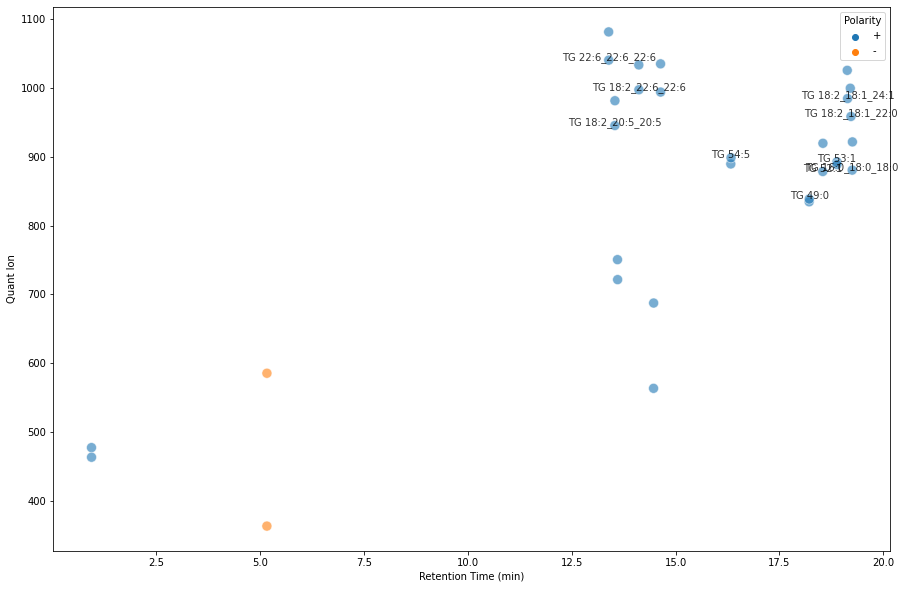

In [95]:
fig, ax = plt.subplots()
# cluster_unique_ids = cluster_membership[0][1]
    
# cluster_unique_ids = [x[1] for x in cluster_membership[:15]]
cluster_unique_ids = [x[1] for x in cluster_membership if len(x[1]) > 1]
cluster_unique_ids = [item for sublist in cluster_unique_ids for item in sublist]  # Flatten the list of lists

subset = fr_filt.loc[fr_filt.index.isin(cluster_unique_ids)]
# subset = cd.loc[cd['chemspider']]
sns.scatterplot(
    data=subset,
#     data=cd, style='Checked', markers={True: 'o', False: 'X'},
    y='Quant Ion',
    x='Retention Time (min)',
    hue='Polarity',
#     size='is_id', sizes={True: 80, False: 25},
    alpha=0.6,
    s=100,
    ax=ax,
)

# PLOT LIPID IDENTIFICATION LABELS OVER DOTS
for i, row in subset.iterrows():
    if str(row['Identification']) != 'nan':
        plt.annotate(row['Identification'], (row['Retention Time (min)'], row['Quant Ion']), 
                 horizontalalignment='center', size='medium', color='black', alpha=0.8,)

fig.set_size_inches(15, 10)
# plt.xlim(1, 19)
# plt.xlim(8, 14)
# plt.ylim(70, 1100)

## It is difficult to filter out using this distance clustering method alone because certain lipids that are distinct (and not in-source frags) simply have close RTs and similar quant profiles.

In [96]:
cluster_unique_ids = [x[1] for x in cluster_membership if len(x[1]) > 1]
mz_diffs = []
for cluster in cluster_unique_ids:
    matrix = np.zeros(shape=(len(cluster), len(cluster)))
    for i, lipid_i in enumerate(cluster):
        for j, lipid_j in enumerate(cluster):
            mz1 = fr_filt.loc[lipid_i, 'Quant Ion']
            mz2 = fr_filt.loc[lipid_j, 'Quant Ion']
            matrix[i][j] = (mz1 - mz2)
            if i == j:
                matrix[i][j] = mz1
    mz_diffs.append(matrix)
for matrix in mz_diffs:
    display(pd.DataFrame(matrix))

,0,1
0,477.38000,14.01599
1,-14.01599,463.36401


,0,1
0,363.25217,-222.23459
1,222.23459,585.48676


,0,1
0,1081.79688,41.02674
1,-41.02674,1040.77014


,0,1
0,945.69379,-36.07135
1,36.07135,981.76514


,0,1
0,750.67639,29.05163
1,-29.05163,721.62476


,0,1
0,1033.79663,36.07141
1,-36.07141,997.72522


,0,1
0,563.53998,-124.05054
1,124.05054,687.59052


,0,1
0,1035.35669,41.02661
1,-41.02661,994.33008


,0,1
0,889.79291,-8.99341
1,8.99341,898.78632


,0,1
0,834.79285,-3.99383
1,3.99383,838.78668


,0,1
0,878.81775,-41.02600
1,41.02600,919.84375


,0,1
0,892.83405,3.99476
1,-3.99476,888.83929


,0,1
0,1025.92249,41.02674
1,-41.02674,984.89575


,0,1
0,999.90656,41.02662
1,-41.02662,958.87994


,0,1
0,880.83392,-41.02619
1,41.02619,921.86011


# Conclusion from in-source fragment searching: after trying many parameters it is difficult to do additional filtering with this method
## Inconclusive whether certain features are truly in-source frags
## Future idea: 
1. Using the deltaMZ calculation from the possible in-source frag cluster, you can try to assign chemical formulas to the neutral loss mass.
2. If a plausible chemical formula appears, you can use that as the basis for the difference. 

# Execute filtering steps 

In [107]:
# Load FAs from BJA-1.0.2
FAs = pd.read_csv(r'../data/interim/FAs_MS1_matched.csv', index_col=0)
FAs

,MS1_match_id
198,FA 14:0
253,FA 16:0
213,FA 16:1
292,FA 17:0
324,FA 18:0
269,FA 18:1
279,FA 18:1
223,FA 18:2
231,FA 18:2
186,FA 18:3


In [120]:
fr_filt.loc[FAs.index, 'is_fa'] = True
fr_filt.loc[:, 'is_fa'].replace(np.nan, False, inplace=True)
fr_filt.loc[FAs.index, 'Identification'] = FAs.values
fr_filt.loc[FAs.index, 'Lipid Class'] = 'FA'
fr_filt.loc[fr_filt['is_fa']]

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11),...,qc_rsd,qc123_rsd,data_rsd,is_id,sample_mean,blank_mean,blank_max,sample_blank_diff,sample_maxblank_diff,is_fa
157,1.996,275.20200,-,20.891508,FA 18:4,FA,4,13.634437,13.540738,19.477947,...,0.008810,0.023198,0.048529,False,19.206236,13.587587,13.634437,5.618648,5.571799,True
164,2.251,301.21777,-,25.559209,FA 20:5,FA,30,14.629904,14.477830,24.699165,...,0.029106,0.020949,0.033932,False,24.010822,14.553867,14.629904,9.456955,9.380919,True
170,2.447,301.21768,-,25.600297,FA 20:5,FA,61,13.680078,13.442485,24.669725,...,0.036952,0.027014,0.031876,False,23.998370,13.561281,13.680078,10.437088,10.318292,True
186,2.651,277.21738,-,24.598685,FA 18:3,FA,5,13.688423,13.549320,23.393111,...,0.054089,0.039101,0.039205,False,22.739655,13.618872,13.688423,9.120783,9.051232,True
190,2.686,327.23318,-,27.051906,FA 22:6,FA,52,14.198059,14.047878,25.810260,...,0.044092,0.032719,0.035214,False,24.948354,14.122969,14.198059,10.825385,10.750295,True
198,2.845,227.20168,-,22.895520,FA 14:0,FA,39,16.126319,15.773363,21.514380,...,0.053422,0.040740,0.045176,False,20.859053,15.949841,16.126319,4.909212,4.732734,True
206,2.952,327.23328,-,27.100302,FA 22:6,FA,62,13.525791,13.388821,26.202975,...,0.032538,0.023260,0.036840,False,24.810990,13.457306,13.525791,11.353684,11.285199,True
209,3.071,315.23346,-,21.023755,FA 21:5,FA,9,13.663249,13.422666,19.949327,...,0.007135,0.016976,0.049789,False,18.981723,13.542958,13.663249,5.438765,5.318473,True
212,3.207,303.23334,-,25.864328,FA 20:4,FA,56,16.169710,14.538578,24.969585,...,0.001931,0.005908,0.030360,False,24.394958,15.354144,16.169710,9.040814,8.225248,True
213,3.220,253.21753,-,24.336712,FA 16:1,FA,2,17.517071,16.592028,23.464379,...,0.016680,0.011914,0.037289,False,22.724411,17.054549,17.517071,5.669862,5.207340,True


In [136]:
fr_final = fr_filt.loc[
  ~(
    (fr_filt['Retention Time (min)'] < 0.8) | 
    (fr_filt['Quant Ion'] < 350) | 
    (fr_filt['sample_maxblank_diff'] < 3) | 
    (fr_filt['Features Found'] < 5) 
   ) | (fr_filt['is_fa'] == True)
]
# fr_final.reset_index(inplace=True, drop=True)
fr_final['Identification'].fillna('unknown', inplace=True)
fr_final['Lipid Class'].fillna('unknown', inplace=True)
print(len(fr_final.loc[fr_final['Lipid Class'] != 'unknown']))
fr_final.loc[fr_final['Lipid Class'] == 'FA']
# fr_final

355


C:\Users\bjanderson23\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11),...,qc_rsd,qc123_rsd,data_rsd,is_id,sample_mean,blank_mean,blank_max,sample_blank_diff,sample_maxblank_diff,is_fa
157,1.996,275.20200,-,20.891508,FA 18:4,FA,4,13.634437,13.540738,19.477947,...,0.008810,0.023198,0.048529,False,19.206236,13.587587,13.634437,5.618648,5.571799,True
164,2.251,301.21777,-,25.559209,FA 20:5,FA,30,14.629904,14.477830,24.699165,...,0.029106,0.020949,0.033932,False,24.010822,14.553867,14.629904,9.456955,9.380919,True
170,2.447,301.21768,-,25.600297,FA 20:5,FA,61,13.680078,13.442485,24.669725,...,0.036952,0.027014,0.031876,False,23.998370,13.561281,13.680078,10.437088,10.318292,True
186,2.651,277.21738,-,24.598685,FA 18:3,FA,5,13.688423,13.549320,23.393111,...,0.054089,0.039101,0.039205,False,22.739655,13.618872,13.688423,9.120783,9.051232,True
190,2.686,327.23318,-,27.051906,FA 22:6,FA,52,14.198059,14.047878,25.810260,...,0.044092,0.032719,0.035214,False,24.948354,14.122969,14.198059,10.825385,10.750295,True
198,2.845,227.20168,-,22.895520,FA 14:0,FA,39,16.126319,15.773363,21.514380,...,0.053422,0.040740,0.045176,False,20.859053,15.949841,16.126319,4.909212,4.732734,True
206,2.952,327.23328,-,27.100302,FA 22:6,FA,62,13.525791,13.388821,26.202975,...,0.032538,0.023260,0.036840,False,24.810990,13.457306,13.525791,11.353684,11.285199,True
209,3.071,315.23346,-,21.023755,FA 21:5,FA,9,13.663249,13.422666,19.949327,...,0.007135,0.016976,0.049789,False,18.981723,13.542958,13.663249,5.438765,5.318473,True
212,3.207,303.23334,-,25.864328,FA 20:4,FA,56,16.169710,14.538578,24.969585,...,0.001931,0.005908,0.030360,False,24.394958,15.354144,16.169710,9.040814,8.225248,True
213,3.220,253.21753,-,24.336712,FA 16:1,FA,2,17.517071,16.592028,23.464379,...,0.016680,0.011914,0.037289,False,22.724411,17.054549,17.517071,5.669862,5.207340,True


In [138]:
# fr_final['unique_identifier'] = \
#     fr_final['Retention Time (min)'].astype('str') + '_' + \
#     fr_final['Quant Ion'].round(3).astype('str') + '_' + \
#     fr_final['Identification']

# col = fr_final.pop("unique_identifier")
# fr_final.insert(0, col.name, col)
fr_final.to_csv(r'..\data\processed\lipidomics_normalized_filtered_data.csv', index=False)

In [69]:
fr_final

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11),...,20210729_AJ_Toh_RatBloodGlucose_T1092M_20210413_10wk_RBG.raw (F46),qc_rsd,qc123_rsd,data_rsd,is_id,sample_mean,blank_mean,blank_max,sample_blank_diff,sample_maxblank_diff
0,0.818,622.29077,+,21.601901,unknown,unknown,19,12.941802,12.860211,19.833947,...,20.379313,0.010783,0.019079,0.031121,False,20.282531,12.901006,12.941802,7.381524,7.340729
1,0.871,453.16891,+,20.579857,unknown,unknown,19,15.573107,14.237157,19.363592,...,19.250024,0.013719,0.009704,0.021801,False,19.749192,14.905132,15.573107,4.844061,4.176086
2,0.873,645.11963,+,21.044106,unknown,unknown,7,14.087519,14.005928,16.952456,...,19.384489,0.007729,0.094309,0.023598,False,20.081812,14.046724,14.087519,6.035089,5.994293
3,0.876,631.34955,-,20.511055,unknown,unknown,10,12.929552,12.888105,18.186927,...,16.585924,0.004717,0.053549,0.060011,False,18.400726,12.908829,12.929552,5.491897,5.471174
4,0.933,376.25961,+,26.282297,unknown,unknown,58,12.595866,12.403226,24.079312,...,22.905409,0.013897,0.011368,0.037807,False,23.802752,12.499546,12.595866,11.303206,11.206886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868,19.885,908.86542,+,22.747233,TG 18:0_18:0_18:0,TG,29,14.966498,15.312007,16.210426,...,19.544042,0.018827,0.122932,0.043977,True,20.379256,15.139252,15.312007,5.240004,5.067250
869,20.144,948.89648,+,21.894233,unknown,unknown,7,13.641698,13.780943,14.322858,...,17.648203,0.026353,0.122800,0.070587,False,18.777856,13.711320,13.780943,5.066536,4.996913
870,20.148,897.82532,+,21.529536,unknown,unknown,15,13.549287,13.688532,18.288838,...,16.927718,0.009788,0.037537,0.058892,False,19.001263,13.618910,13.688532,5.382353,5.312730
871,20.175,593.58716,+,21.430516,unknown,unknown,19,13.716785,13.856031,15.868179,...,16.687194,0.016618,0.119397,0.067397,False,18.908803,13.786408,13.856031,5.122395,5.052772


In [85]:
# drop rows with RSD > 0.5 (50%) as found in QC2 and QC3
# 50% ensures we filter out the reeeally bad features, because we only have 2 good QCs
high_RSD_rows = fr_norm[(fr_norm.filter(regex='QC2|QC3').std(axis=1)/fr_norm.filter(regex='QC2|QC3').mean(axis=1)) > 0.5].index
fr_filt = fr_norm.drop(high_RSD_rows)

fr_filt = fr_filt.drop(fr_filt.filter(regex='Blank|Water|QC1|QC3').columns, axis=1)

# Fill unknowns in Identification and Lipid Class column with 'unknown'
fr_filt['Identification'] = fr_filt['Identification'].fillna('unknown')
fr_filt['Lipid Class'] = fr_filt['Lipid Class'].fillna('unknown')

# Change 'Quant Ion' to dtype 'str' to allow concatenation
fr_filt['Quant Ion'] = fr_filt['Quant Ion'].astype('str')
fr_filt['Retention Time (min)'] = fr_filt['Retention Time (min)'].astype('str')
# Make new unique identifer for each feature
fr_filt['Unique Identifier'] = fr_filt['Identification'] + '_' + \
                                    fr_filt['Quant Ion'] + '_' + fr_filt['Retention Time (min)']
fr_filt['Unique Identifier'] = fr_filt['Unique Identifier'].str.replace(' ', '_')

# Change order to put Unique Identifier column first:
cols_to_order = ['Unique Identifier']
new_columns = cols_to_order + (fr_filt.columns.drop(cols_to_order).tolist())
fr_filt = fr_filt[new_columns]

# rename cols to remove '.raw (F46)'
# cols_to_rename = fr_filt.filter(regex='.raw').columns.to_list()
# fr_filt = fr_filt.rename({col: col.split('.raw')[0] for col in cols_to_rename}, axis='columns')

# drop rows with Features Found in only 2 or 3. 
fr_filt = fr_filt[fr_filt['Features Found'] > 3]

# fr_filt.to_csv(r'..\reports\collaborator reports\preliminary 20210812\lipidomics_normalized_filtered_data.csv', index=False)
# fr_filt.to_csv(r'..\data\processed\lipidomics_normalized_filtered_data.csv', index=False)

fr_filt

,Unique Identifier,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw (F4),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210402_9wk_FBG.raw (F55),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210406_9wk_RBG.raw (F56),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210410_10wk_FBG.raw (F57),20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64)
0,unknown_498.05923_0.523,0.523,498.05923,+,7.872146e+06,unknown,unknown,29,1.598270e+06,3.477907e+06,...,7.482146e+05,4.463731e+05,1.180452e+06,3.538000e+06,1.730074e+06,1.489243e+06,1.125232e+06,1.101206e+06,1.361599e+06,6.094836e+05
2,unknown_329.03067_0.53,0.53,329.03067,-,2.143586e+08,unknown,unknown,48,1.157294e+08,1.149936e+08,...,1.264605e+08,9.407673e+07,5.422188e+07,1.903617e+08,5.550014e+07,1.003165e+08,9.137050e+07,1.353586e+08,1.056959e+08,1.222089e+08
6,unknown_352.99805_0.534,0.534,352.99805,-,4.896796e+06,unknown,unknown,88,1.832222e+06,3.198166e+06,...,3.625228e+06,1.742238e+06,1.617177e+06,3.950322e+06,1.666802e+06,2.621127e+06,2.911391e+06,2.724274e+06,2.633354e+06,2.996629e+06
8,unknown_951.15942_0.539,0.539,951.15942,-,2.145503e+07,unknown,unknown,81,1.292816e+07,2.094151e+07,...,1.118966e+07,1.011052e+07,1.113656e+07,9.856785e+06,8.874998e+06,6.457099e+06,9.721185e+06,1.130233e+07,1.111576e+07,8.472362e+06
9,unknown_347.00339_0.541,0.541,347.00339,-,1.458703e+07,unknown,unknown,58,4.415869e+06,4.774960e+06,...,1.086478e+07,6.135326e+06,6.239275e+06,1.073320e+07,7.236947e+06,5.046515e+06,7.667585e+06,2.834923e+06,7.175370e+06,2.507755e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1487,unknown_593.58734_19.566,19.566,593.58734,+,1.189414e+06,unknown,unknown,32,6.335012e+05,8.479828e+04,...,4.494104e+05,1.426543e+05,2.182494e+05,1.275738e+05,4.819977e+05,1.211516e+05,3.898376e+05,2.472727e+05,6.147797e+05,8.976412e+04
1488,unknown_931.88025_19.569,19.569,931.88025,+,1.154313e+06,unknown,unknown,31,6.578125e+05,1.421619e+05,...,3.368623e+05,2.171430e+05,2.566360e+05,1.327089e+05,4.574912e+05,1.678007e+05,3.616448e+05,3.615331e+05,5.562583e+05,1.291938e+05
1489,unknown_897.82526_20.151,20.151,897.82526,+,1.746195e+06,unknown,unknown,35,8.069193e+05,1.624971e+05,...,4.939620e+05,2.147538e+05,1.770322e+05,1.833340e+05,5.105076e+05,1.757772e+05,3.562443e+05,3.641340e+05,6.455546e+05,9.869604e+04
1490,unknown_593.58716_20.178,20.178,593.58716,+,2.096565e+06,unknown,unknown,36,9.145948e+05,1.346091e+05,...,5.781031e+05,2.027713e+05,2.419253e+05,1.627173e+05,6.368835e+05,1.747728e+05,4.628786e+05,3.334793e+05,8.443657e+05,1.286536e+05


In [17]:
fr_filt['Unique Identifier'].nunique()

1029

In [ ]:
excel_writer = pd.ExcelWriter(r'..\reports\collaborator reports\preliminary 20210812\24 Aug 2021 Nile rat Lipidomics data.xlsx')

fr_filt.to_excel(excel_writer, sheet_name='Lipidomics normalized filtered', index=False)
fr_norm.to_excel(excel_writer, sheet_name='Lipidomics normalized')
fr_raw.to_excel(excel_writer, sheet_name='Lipidomics raw')

excel_writer.save()
excel_writer.close()

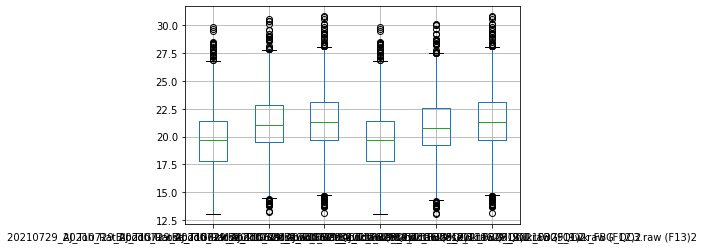

In [18]:
## Comparing pre-normalization raw data QC boxplots vs post-normalization QC boxplots
np.log2(fr_raw.filter(regex='QC')).join(np.log2(fr_norm.filter(regex='QC')), lsuffix='1', rsuffix='2').plot.box()
plt.grid(alpha=1)

<AxesSubplot:>

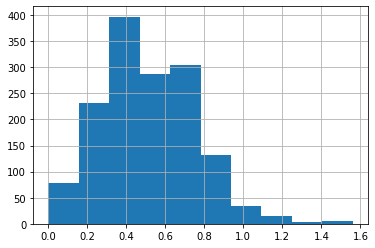

In [19]:
(fr_raw.filter(regex='QC').std(axis=1)/fr_raw.filter(regex='QC').mean(axis=1)).hist()

False    1099
True      388
dtype: int64


<AxesSubplot:>

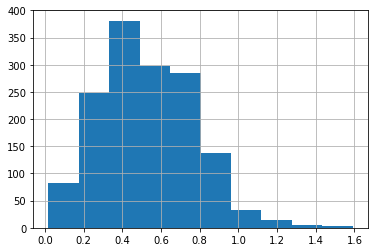

In [20]:
# RSDs of all 3 QCs
all_qc_rsd = fr_norm.filter(regex='QC').std(axis=1)/fr_norm.filter(regex='QC').mean(axis=1)
print((all_qc_rsd > 0.7).value_counts())
all_qc_rsd.hist()

<AxesSubplot:>

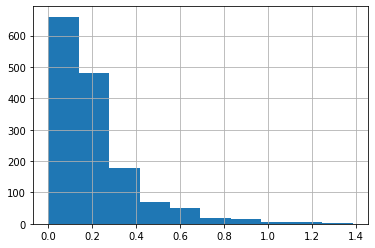

In [21]:
(fr_raw.filter(regex='QC2|QC3').std(axis=1)/fr_raw.filter(regex='QC2|QC3').mean(axis=1)).hist()

False    1302
True      185
dtype: int64


<AxesSubplot:>

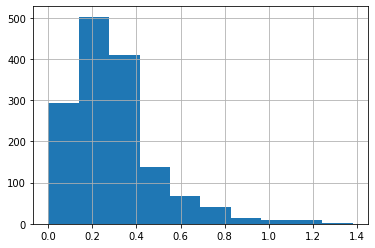

In [22]:
qc2_qc3_rsd = fr_norm.filter(regex='QC2|QC3').std(axis=1)/fr_norm.filter(regex='QC2|QC3').mean(axis=1)
print((qc2_qc3_rsd > 0.5).value_counts())
qc2_qc3_rsd.hist()
